# **Building a Scalable Movie Recommendation System Using Apache Spark**

1. Load and preprocess dataset
2. Implement, Train and Evaluate ALS model
3. Optimize model
4. Recommendations with ALS


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, when, explode
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import from_unixtime, year, month, dayofweek
from pyspark.sql.functions import regexp_extract, split, explode
from google.colab import drive

## 1. Load and preprocess dataset in Spark

---



In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Start Spark Session
spark = SparkSession.builder.appName("MovieLens 1M").getOrCreate()

In [ ]:
# Download and unzip the MovieLens 1M dataset
!wget https://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip -o ml-1m.zip


--2025-05-29 13:41:18--  https://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip’

ml-1m.zip           100%[===================>]   5.64M  15.8MB/s    in 0.4s    

2025-05-29 13:41:19 (15.8 MB/s) - ‘ml-1m.zip’ saved [5917549/5917549]

Archive:  ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         


In [ ]:
# Ratings: userId, movieId, rating, timestamp
ratings_df = spark.read.csv("ml-1m/ratings.dat", sep="::", inferSchema=True, header=False)
ratings_df = ratings_df.withColumnRenamed("_c0", "userId") \
                       .withColumnRenamed("_c1", "movieId") \
                       .withColumnRenamed("_c2", "rating") \
                       .withColumnRenamed("_c3", "timestamp")

# Users: userId, gender, age, occupation, zip
users_df = spark.read.csv("ml-1m/users.dat", sep="::", inferSchema=True, header=False)
users_df = users_df.withColumnRenamed("_c0", "userId") \
                   .withColumnRenamed("_c1", "gender") \
                   .withColumnRenamed("_c2", "age") \
                   .withColumnRenamed("_c3", "occupation") \
                   .withColumnRenamed("_c4", "zip")

# Movies: movieId, title, genres
movies_df = spark.read.csv("ml-1m/movies.dat", sep="::", inferSchema=True, header=False)
movies_df = movies_df.withColumnRenamed("_c0", "movieId") \
                     .withColumnRenamed("_c1", "title") \
                     .withColumnRenamed("_c2", "genres")

In [ ]:
# Check null value - Ratings
null_counts = ratings_df.select([
    sum(when(col(c).isNull(), 1).otherwise(0)).alias(c)
    for c in ratings_df.columns
])

null_counts.show()

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     0|      0|     0|        0|
+------+-------+------+---------+



In [ ]:
# Check null value - Users
null_counts = users_df.select([
    sum(when(col(c).isNull(), 1).otherwise(0)).alias(c)
    for c in users_df.columns
])

null_counts.show()

+------+------+---+----------+---+
|userId|gender|age|occupation|zip|
+------+------+---+----------+---+
|     0|     0|  0|         0|  0|
+------+------+---+----------+---+



In [ ]:
# Check null value - Movies
null_counts = movies_df.select([
    sum(when(col(c).isNull(), 1).otherwise(0)).alias(c)
    for c in movies_df.columns
])

null_counts.show()

+-------+-----+------+
|movieId|title|genres|
+-------+-----+------+
|      0|    0|     0|
+-------+-----+------+



In [ ]:
users_df.show(5)

+------+------+---+----------+-----+
|userId|gender|age|occupation|  zip|
+------+------+---+----------+-----+
|     1|     F|  1|        10|48067|
|     2|     M| 56|        16|70072|
|     3|     M| 25|        15|55117|
|     4|     M| 45|         7|02460|
|     5|     M| 25|        20|55455|
+------+------+---+----------+-----+
only showing top 5 rows



In [ ]:
# ratings_df — Add Time Features
ratings_df = ratings_df.withColumn("datetime", from_unixtime("timestamp")) \
                       .withColumn("rating_year", year("datetime")) \
                       .withColumn("rating_month", month("datetime")) \
                       .withColumn("rating_dayofweek", dayofweek("datetime"))

# movies_df — Parse Genres and Year
movies_df = movies_df.withColumn("year", regexp_extract("title", r"\((\d{4})\)", 1).cast("int"))
movies_df = movies_df.withColumn("clean_title", regexp_extract("title", r"^(.*)\s\(\d{4}\)$", 1))
movies_df = movies_df.withColumn("genre_array", split("genres", "\\|"))

# Join ratings with users
ratings_users = ratings_df.join(users_df, on="userId", how="left")

# Join with movies
full_df = ratings_users.join(movies_df, on="movieId", how="left")


In [ ]:
def calculate_precision_recall(predictions, threshold=4.0):
    predictions = predictions.withColumn("relevant", when(col("rating") >= threshold, 1).otherwise(0))
    predictions = predictions.withColumn("recommended", when(col("prediction") >= threshold, 1).otherwise(0))

    tp = predictions.filter((col("relevant") == 1) & (col("recommended") == 1)).count()
    fp = predictions.filter((col("relevant") == 0) & (col("recommended") == 1)).count()
    fn = predictions.filter((col("relevant") == 1) & (col("recommended") == 0)).count()

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0

    return precision, recall

## 2. Implement, Train and Evaluate ALS model

---



In [ ]:
# Select ALS-required columns
als_input = ratings_df.select("userId", "movieId", "rating")

# Split into training/test
(training, test) = als_input.randomSplit([0.8, 0.2])

# Initialize ALS model
als = ALS(
    userCol="userId",
    itemCol="movieId",
    ratingCol="rating",
    rank=10,
    maxIter=10,
    regParam=0.1,
    coldStartStrategy="drop",
    nonnegative=True
)

In [ ]:
# Fit model
model = als.fit(training)

# Make predictions
predictions = model.transform(test)

# Evaluate
evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol="rating",
    predictionCol="prediction"
)
rmse = evaluator.evaluate(predictions)

evaluator_mae = RegressionEvaluator(
    metricName="mae",
    labelCol="rating",
    predictionCol="prediction"
)
mae = evaluator_mae.evaluate(predictions)

evaluator_r2 = RegressionEvaluator(
    metricName="r2",
    labelCol="rating",
    predictionCol="prediction"
)
r2 = evaluator_r2.evaluate(predictions)

# Calculate Precision and Recall
precision, recall = calculate_precision_recall(predictions, threshold=4.0)

print(f"Root-mean-square error = {rmse:.4f}")
print(f"MAE = {mae:.4f}")
print(f"R² = {r2:.4f}")
print(f"Precision = {precision:.4f}")
print(f"Recall = {recall:.4f}")

Root-mean-square error = 0.8751
MAE = 0.7018
R² = 0.3881
Precision = 0.9144
Recall = 0.2976


## 3. Optimize model

---


In [ ]:
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt

# Define hyperparameter grids
rank_values = [5, 10]
max_iter_values = [5, 10, 15]
reg_param_values = [0.01, 0.1, 0.5]

# Initialize lists to store results
results = []  # To store (rank, maxIter, regParam, rmse, mae, r2, precision, recall) for each combination

# Select ALS-required columns
als_input = ratings_df.select("userId", "movieId", "rating")

# Split into training/test
(training, test) = als_input.randomSplit([0.8, 0.2])

# Grid search over all combinations
for rank in rank_values:
    for max_iter in max_iter_values:
        for reg_param in reg_param_values:
            # Initialize ALS model
            als = ALS(
                userCol="userId",
                itemCol="movieId",
                ratingCol="rating",
                rank=rank,
                maxIter=max_iter,
                regParam=reg_param,
                coldStartStrategy="drop",
                nonnegative=True
            )

            # Fit the model
            model = als.fit(training)

            # Make predictions
            predictions = model.transform(test)

            # Evaluate RMSE
            evaluator_rmse = RegressionEvaluator(
                metricName="rmse",
                labelCol="rating",
                predictionCol="prediction"
            )
            rmse = evaluator_rmse.evaluate(predictions)

            # Evaluate MAE
            evaluator_mae = RegressionEvaluator(
                metricName="mae",
                labelCol="rating",
                predictionCol="prediction"
            )
            mae = evaluator_mae.evaluate(predictions)

            # Evaluate R²
            evaluator_r2 = RegressionEvaluator(
                metricName="r2",
                labelCol="rating",
                predictionCol="prediction"
            )
            r2 = evaluator_r2.evaluate(predictions)

            # Calculate Precision and Recall
            precision, recall = calculate_precision_recall(predictions, threshold=4.0)

            # Store results
            results.append((rank, max_iter, reg_param, rmse, mae, r2, precision, recall))

            # Print results for each combination
            print(f"rank={rank}, maxIter={max_iter}, regParam={reg_param}")
            print(f"Precision = {precision:.4f}")
            print(f"Recall = {recall:.4f}")
            print(f"RMSE = {rmse:.4f}")
            print(f"MAE = {mae:.4f}")
            print(f"R² = {r2:.4f}")
            print("---")

rank=5, maxIter=5, regParam=0.01
Precision = 0.8751
Recall = 0.3869
RMSE = 0.8845
MAE = 0.6992
R² = 0.3691
---
rank=5, maxIter=5, regParam=0.1
Precision = 0.9244
Recall = 0.2099
RMSE = 0.9110
MAE = 0.7391
R² = 0.3306
---
rank=5, maxIter=5, regParam=0.5
Precision = 0.9324
Recall = 0.0817
RMSE = 1.0229
MAE = 0.8460
R² = 0.1561
---
rank=5, maxIter=10, regParam=0.01
Precision = 0.8768
Recall = 0.4108
RMSE = 0.8722
MAE = 0.6876
R² = 0.3864
---
rank=5, maxIter=10, regParam=0.1
Precision = 0.9082
Recall = 0.2930
RMSE = 0.8819
MAE = 0.7079
R² = 0.3727
---
rank=5, maxIter=10, regParam=0.5
Precision = 0.9347
Recall = 0.0655
RMSE = 1.0405
MAE = 0.8632
R² = 0.1268
---
rank=5, maxIter=15, regParam=0.01
Precision = 0.8768
Recall = 0.4220
RMSE = 0.8687
MAE = 0.6839
R² = 0.3914
---
rank=5, maxIter=15, regParam=0.1
Precision = 0.9013
Recall = 0.3235
RMSE = 0.8751
MAE = 0.6997
R² = 0.3824
---
rank=5, maxIter=15, regParam=0.5
Precision = 0.9350
Recall = 0.0649
RMSE = 1.0413
MAE = 0.8639
R² = 0.1255
---
r

In [ ]:
# Find the best model based on the lowest RMSE
best_result = min(results, key=lambda x: x[3])  # x[3] is RMSE
best_rank, best_max_iter, best_reg_param, best_rmse, best_mae, best_r2, best_precision, best_recall = best_result

print(f"Best Model: rank={best_rank}, maxIter={best_max_iter}, regParam={best_reg_param}")
print(f"Best RMSE = {best_rmse:.4f}")
print(f"Best MAE = {best_mae:.4f}")
print(f"Best R² = {best_r2:.4f}")
print(f"Best Precision = {best_precision:.4f}")
print(f"Best Recall = {best_recall:.4f}")

Best Model: rank=10, maxIter=15, regParam=0.1
Best RMSE = 0.8665
Best MAE = 0.6926
Best R² = 0.3944
Best Precision = 0.9083
Best Recall = 0.3291


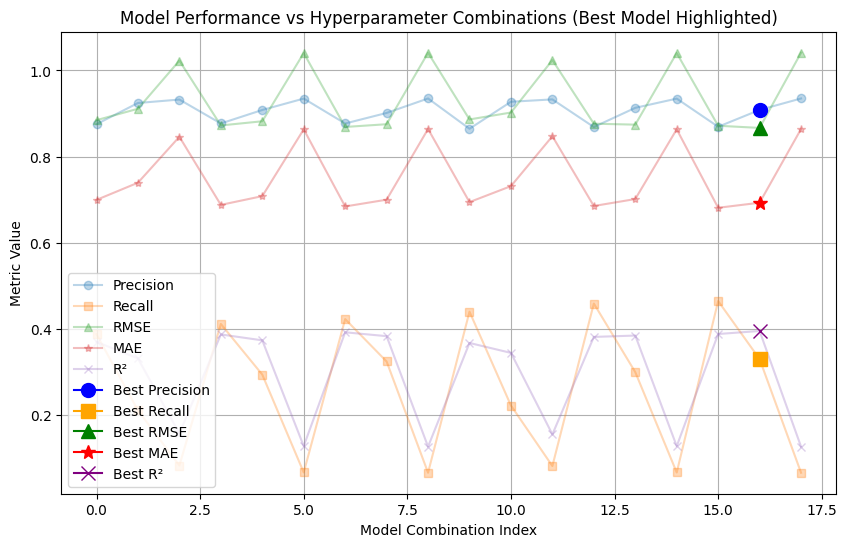

In [ ]:
import matplotlib.pyplot as plt

# Assuming results and best_result are defined from your grid search
# Extract metrics for plotting
ranks = [r[0] for r in results]
max_iters = [r[1] for r in results]
reg_params = [r[2] for r in results]
rmses = [r[3] for r in results]
maes = [r[4] for r in results]
r2s = [r[5] for r in results]
precisions = [r[6] for r in results]
recalls = [r[7] for r in results]

# Find the index of the best model (based on RMSE)
best_idx = results.index(best_result)

plt.figure(figsize=(10, 6))
plt.plot(range(len(results)), precisions, label="Precision", marker='o', color='#1f77b4', alpha=0.3)
plt.plot(range(len(results)), recalls, label="Recall", marker='s', color='#ff7f0e', alpha=0.3)
plt.plot(range(len(results)), rmses, label="RMSE", marker='^', color='#2ca02c', alpha=0.3)
plt.plot(range(len(results)), maes, label="MAE", marker='*', color='#d62728', alpha=0.3)
plt.plot(range(len(results)), r2s, label="R²", marker='x', color='#9467bd', alpha=0.3)

# Highlight the best model
plt.plot(best_idx, precisions[best_idx], marker='o', color='blue', markersize=10, label="Best Precision")
plt.plot(best_idx, recalls[best_idx], marker='s', color='orange', markersize=10, label="Best Recall")
plt.plot(best_idx, rmses[best_idx], marker='^', color='green', markersize=10, label="Best RMSE")
plt.plot(best_idx, maes[best_idx], marker='*', color='red', markersize=10, label="Best MAE")
plt.plot(best_idx, r2s[best_idx], marker='x', color='purple', markersize=10, label="Best R²")

plt.xlabel("Model Combination Index")
plt.ylabel("Metric Value")
plt.title("Model Performance vs Hyperparameter Combinations (Best Model Highlighted)")
plt.legend()
plt.grid(True)
plt.show()

## 4. Recommendations with ALS

---


In [ ]:
# Top 10 movies for each users
user_recommendations = model.recommendForAllUsers(10)

# Or: Top 10 users for each movies
movie_recommendations = model.recommendForAllItems(10)

In [ ]:
# Show top 10 movies and ratings for first 5 users
user_recommendations.show(5, truncate=False)

+------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|userId|recommendations                                                                                                                                                                          |
+------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|1     |[{3382, 6.3756404}, {557, 4.8772187}, {989, 4.6178493}, {1471, 4.529534}, {578, 4.51008}, {787, 4.4664664}, {3233, 4.452823}, {2503, 4.440986}, {3607, 4.42256}, {3245, 4.382984}]       |
|3     |[{3382, 6.0458055}, {557, 4.6249027}, {989, 4.3789515}, {1471, 4.295205}, {578, 4.2767577}, {787, 4.2354007}, {3233, 4.2224627}, {2503, 4.2112374}, {3607, 4.1937656}, {3245, 4.1562366}]|
|5     |[{3382, 5.052091}

In [ ]:
# Explode the 'recommendations' array and extract movieId and predicted rating
recs_exploded = user_recommendations.withColumn("rec", explode("recommendations")) \
    .select("userId", col("rec.movieId").alias("movieId"), col("rec.rating").alias("predicted_rating"))

# Join with the movies DataFrame to add movie titles to the recommendations.
recommendation_with_titles = recs_exploded.join(movies_df.select("movieId", "title"), on="movieId", how="left")

# Display the top 10 recommendations for each user, ordered by predicted rating
recommendation_with_titles.orderBy("userId", "predicted_rating", ascending=False).show(10, truncate=False)

+-------+------+----------------+------------------------------------------------+
|movieId|userId|predicted_rating|title                                           |
+-------+------+----------------+------------------------------------------------+
|1002   |6040  |4.6521387       |Ed's Next Move (1996)                           |
|2760   |6040  |4.598718        |Gambler, The (A J�t�kos) (1997)                 |
|2503   |6040  |4.5470777       |Apple, The (Sib) (1998)                         |
|2931   |6040  |4.534244        |Time of the Gypsies (Dom za vesanje) (1989)     |
|3415   |6040  |4.507103        |Mirror, The (Zerkalo) (1975)                    |
|3817   |6040  |4.493934        |Other Side of Sunday, The (S�ndagsengler) (1996)|
|3134   |6040  |4.488155        |Grand Illusion (Grande illusion, La) (1937)     |
|2925   |6040  |4.468696        |Conformist, The (Il Conformista) (1970)         |
|3532   |6040  |4.446922        |Freedom for Us (� nous la libert� ) (1931)      |
|53 

In [ ]:
# Show top 10 recommendations movies for userId = 1 with titles
recommendation_with_titles.show(10, truncate=False)

+-------+------+----------------+-------------------------------------------------------+
|movieId|userId|predicted_rating|title                                                  |
+-------+------+----------------+-------------------------------------------------------+
|572    |1     |5.554469        |Foreign Student (1994)                                 |
|1851   |1     |4.8592935       |Leather Jacket Love Story (1997)                       |
|2776   |1     |4.760738        |Marcello Mastroianni: I Remember Yes, I Remember (1997)|
|3233   |1     |4.7156014       |Smashing Time (1967)                                   |
|527    |1     |4.5603824       |Schindler's List (1993)                                |
|2931   |1     |4.5535135       |Time of the Gypsies (Dom za vesanje) (1989)            |
|318    |1     |4.5166492       |Shawshank Redemption, The (1994)                       |
|858    |1     |4.473865        |Godfather, The (1972)                                  |
|1002   |1

In [ ]:
# Define path in Google Drive (ensure the directory doesn't already exist)
model_path = "/content/drive/MyDrive/"

# Save model to Drive
model.save(model_path)